This notebook is a test implementation using Deep Learning via a Convolutional Neural Network (CNN) that identifies birds in a set of given images. It uses Keras within TensorFlow to build the CNN and fit the model using training and testing sets of images.

In [1]:
%tensorflow_version 2.x
import numpy as np                            # Numerical library
import os
import sys                                    # System library (to read arguments from command line)
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Tensorflow version {}".format(tf.__version__))

TensorFlow 2.x selected.
Tensorflow version 2.1.0-rc1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Function to split the data:

In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
          files.append(filename)
      else:
          print(filename + " is zero length, so ignoring.")

  print('total length = {}'.format(len(files)))
  training_length = int(len(files) * SPLIT_SIZE)
  print('training length = {}'.format(training_length))
  testing_length = int(len(files) - training_length)
  print('testing length = {}'.format(testing_length))
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
      this_file = SOURCE + filename
      destination = TRAINING + filename
      shutil.copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE + filename
      destination = TESTING + filename
      shutil.copyfile(this_file, destination)
  return

Function to clean a given folder:

In [0]:
def clean_folder(folder):
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete {}. Reason: {}'.format(file_path, e))
  return

In [0]:
split_files = False
learning_rate = 0.001
split_size = .7
epochs = 5
batch_size = 10
dropout_ratio = 0.1

In [0]:
  #POSITIVE_SOURCE_DIR = "./bird/"
  TRAINING_DIR = "/content/drive/My Drive/data_sets/training/"
  TRAINING_POSITIVE_DIR = TRAINING_DIR + "birds/"
  TRAINING_NEGATIVE_DIR = TRAINING_DIR + "nobirds/"
  #NEGATIVE_SOURCE_DIR = "./nobird/"
  TESTING_DIR = "/content/drive/My Drive/data_sets/testing/"
  TESTING_POSITIVE_DIR = TESTING_DIR + "birds/"
  TESTING_NEGATIVE_DIR = TESTING_DIR + "nobirds/"

In [7]:
  if split_files is True:
    print("Cleaning directories...")
    split.clean_folder(TRAINING_POSITIVE_DIR)
    split.clean_folder(TESTING_POSITIVE_DIR)
    split.clean_folder(TRAINING_NEGATIVE_DIR)
    split.clean_folder(TESTING_NEGATIVE_DIR)
    print("Splitting data randomly...")
    split.split_data(POSITIVE_SOURCE_DIR, TRAINING_POSITIVE_DIR, TESTING_POSITIVE_DIR, split_size)
    split.split_data(NEGATIVE_SOURCE_DIR, TRAINING_NEGATIVE_DIR, TESTING_NEGATIVE_DIR, split_size)
    print("Done.")
  else:
    print("Data is already splitted.")

  print( 'Positive training folder {} contains {} files'.format(TRAINING_POSITIVE_DIR,len(os.listdir(TRAINING_POSITIVE_DIR))) )
  print( 'Negative training folder {} contains {} files'.format(TRAINING_NEGATIVE_DIR,len(os.listdir(TRAINING_NEGATIVE_DIR))) )
  print( 'Positive testing folder {} contains {} files'.format(TESTING_POSITIVE_DIR,len(os.listdir(TESTING_POSITIVE_DIR))) )
  print( 'Negative testing folder {} contains {} files'.format(TESTING_NEGATIVE_DIR,len(os.listdir(TESTING_NEGATIVE_DIR))) )
  print( 'Split size chosen: {:5.2f} , split size obtained: {:5.2f} for positive, {:5.2f} for negative'.format(split_size*100.0,float(len(os.listdir(TRAINING_POSITIVE_DIR))/(len(os.listdir(TRAINING_POSITIVE_DIR))+len(os.listdir(TESTING_POSITIVE_DIR))))*100.0,float(len(os.listdir(TRAINING_NEGATIVE_DIR))/(len(os.listdir(TRAINING_NEGATIVE_DIR))+len(os.listdir(TESTING_NEGATIVE_DIR))))*100.0 ) )


Data is already splitted.
Positive training folder /content/drive/My Drive/data_sets/training/birds/ contains 2306 files
Negative training folder /content/drive/My Drive/data_sets/training/nobirds/ contains 2794 files
Positive testing folder /content/drive/My Drive/data_sets/testing/birds/ contains 988 files
Negative testing folder /content/drive/My Drive/data_sets/testing/nobirds/ contains 1198 files
Split size chosen: 70.00 , split size obtained: 70.01 for positive, 69.99 for negative


Getting the files to print examples

In [8]:
POSITIVE_FILES = os.listdir(TRAINING_POSITIVE_DIR)
print(POSITIVE_FILES[:5])

NEGATIVE_FILES = os.listdir(TRAINING_NEGATIVE_DIR)
print(NEGATIVE_FILES[:5])

['2019-10-29-11-40-47.jpg', '2019-08-03-19-14-10.jpg', '2019-10-23-18-01-01.jpg', '2019-06-21-11-07-19.jpg', '2019-10-22-13-51-21.jpg']
['2019-06-19-18-36-34.jpg', '2019-12-12-18-53-24.jpg', '2019-04-13-12-02-55.jpg', '2019-07-29-13-33-11.jpg', '2019-08-10-13-46-02.jpg']


Sample positive images:


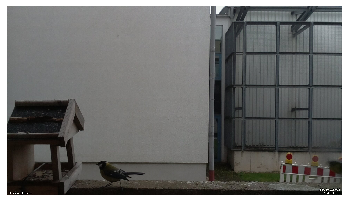

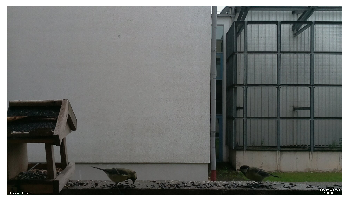

Sample negative images:


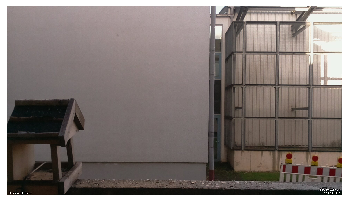

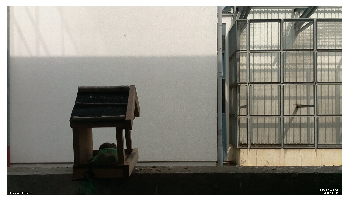

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# How many of each
pic_index = 10
n_images = 2

next_positive = [os.path.join(TRAINING_POSITIVE_DIR, fname) 
                for fname in POSITIVE_FILES[pic_index-n_images:pic_index]]
next_negative = [os.path.join(TRAINING_NEGATIVE_DIR, fname) 
                for fname in NEGATIVE_FILES[pic_index-n_images:pic_index]]

print("Sample positive images:")
for img_path in next_positive:
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
print("Sample negative images:")
for img_path in next_negative:
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()  

Defining the model:

In [10]:
  checkpoint_path = "/content/drive/My Drive/data_sets/"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(1080, 1920, 3)),
      tf.keras.layers.MaxPooling2D(3, 3),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(3, 3),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(3, 3),
      # tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
      # tf.keras.layers.MaxPooling2D(5, 5),
      # tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
      # tf.keras.layers.MaxPooling2D(5, 5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      # tf.keras.layers.Dropout(dropout_ratio),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1078, 1918, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 359, 639, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 357, 637, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 212, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 210, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 70, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 174720)            0

In [11]:
  print("Traning set:")
  train_datagen = ImageDataGenerator(rescale=1./255,
#                                     rotation_range=40,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     shear_range=0.2,
#                                     zoom_range=0.2,
#                                     horizontal_flip=False,
                                     fill_mode='nearest'
                                     )
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      target_size=(1080, 1920))

  print("Testing set:")
  VALIDATION_DIR = TESTING_DIR
  # Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
  validation_datagen = ImageDataGenerator(rescale=1./255,
#                                          rotation_range=40,
#                                          width_shift_range=0.2,
#                                          height_shift_range=0.2,
#                                          shear_range=0.2,
#                                          zoom_range=0.2,
#                                          horizontal_flip=False,
                                          fill_mode='nearest'
                                          )
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                batch_size=batch_size,
                                                                class_mode='binary',
                                                                target_size=(1080, 1920))

Traning set:
Found 5100 images belonging to 2 classes.
Testing set:
Found 2186 images belonging to 2 classes.


The next cell compliles a model with variable Learning Rate, such that an optimal one can be found.

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 2))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
history = model.fit(train_generator, epochs=epochs, callbacks=[lr_schedule])

  ...
    to  
  ['...']
Train for 510 steps
Epoch 1/12
510/510 [==============================] - 280s 549ms/step - loss: 0.6903 - acc: 0.5867
Epoch 2/12
510/510 [==============================] - 278s 545ms/step - loss: 0.6885 - acc: 0.6092
Epoch 3/12
510/510 [==============================] - 277s 542ms/step - loss: 0.6825 - acc: 0.6451
Epoch 4/12
510/510 [==============================] - 272s 534ms/step - loss: 0.6506 - acc: 0.6631
Epoch 5/12
510/510 [==============================] - 272s 532ms/step - loss: 0.5359 - acc: 0.7396
Epoch 6/12
510/510 [==============================] - 272s 534ms/step - loss: 0.4286 - acc: 0.8018
Epoch 7/12
510/510 [==============================] - 272s 533ms/step - loss: 0.4144 - acc: 0.8204
Epoch 8/12
510/510 [==============================] - 271s 532ms/step - loss: 0.5062 - acc: 0.7641
Epoch 9/12
510/510 [==============================] - 274s 536ms/step - loss: 0.6952 - acc: 0.5263
Epoch 10/12
510/510 [==============================] - 275s 540m

Plotting the loss as a function of the learning rate. A good choice of learning rate is the one with minimum loss before it gets unstable.

(5.308844298272577e-06,
 5.956621518660756,
 0.38312518517249355,
 1.0717830943615705)

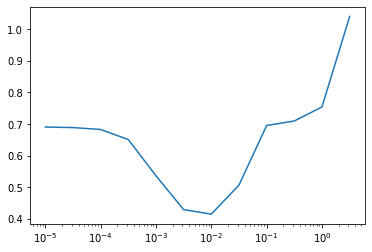

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis()

After the learning rate is chosen, the next cell can be run to train using it and also including a validation set.

First load weights:

In [12]:
model.load_weights(checkpoint_path)

In [16]:
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   save_weights_only=True,
                                                   verbose=1)

  model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy', metrics=['acc'])

  history = model.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      callbacks=[cp_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 510 steps, validate for 219 steps
Epoch 1/5
509/510 [============================>.] - ETA: 7s - loss: 0.1631 - acc: 0.9717 
Epoch 00001: saving model to /content/drive/My Drive/data_sets/
510/510 [==============================] - 5230s 10s/step - loss: 0.1628 - acc: 0.9718 - val_loss: 0.3120 - val_acc: 0.9382
Epoch 2/5
509/510 [============================>.] - ETA: 0s - loss: 0.1103 - acc: 0.9733
Epoch 00002: saving model to /content/drive/My Drive/data_sets/
510/510 [==============================] - 332s 650ms/step - loss: 0.1101 - acc: 0.9733 - val_loss: 0.2526 - val_acc: 0.9511
Epoch 3/5
509/510 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9735
Epoch 00003: saving model to /content/drive/My Drive/data_sets/
510/510 [==============================] - 328s 644ms/step - loss: 0.1120 - acc: 0.9735 - val_loss: 1.0276 - val_acc: 0.8998
Epoch 4/5
509/510 [============================>.] - ETA: 0s - loss: 

Manually save the weights:

In [0]:
model.save_weights(checkpoint_path)

Save the model:

In [0]:
model.save("birds_model.h5")

Visualizing the learning:

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

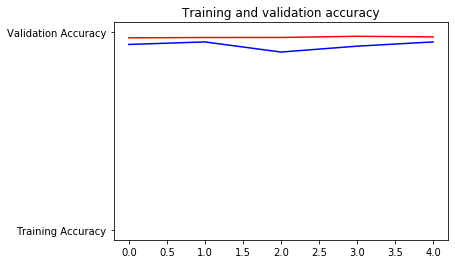

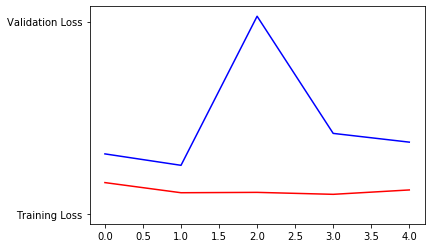

<Figure size 432x288 with 0 Axes>

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

The following code prints sample images where the guess of the model is incorrect.

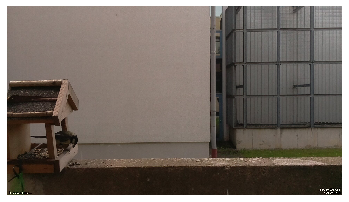

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[1.]]


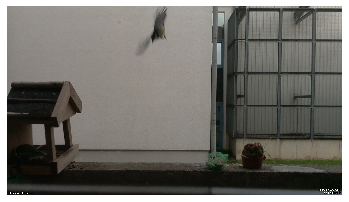

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[1.]]


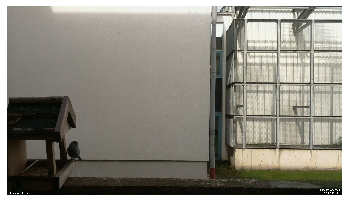

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[1.]]


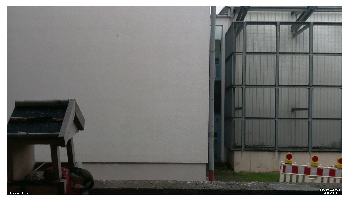

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[1.]]


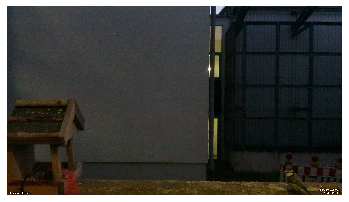

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[1.]]


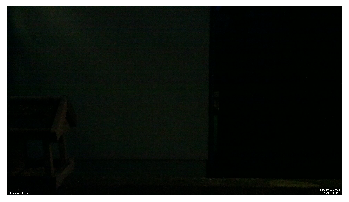

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[0.]]


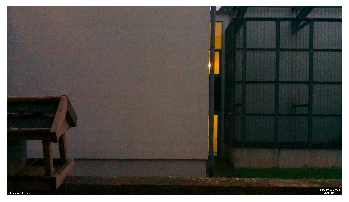

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[0.]]


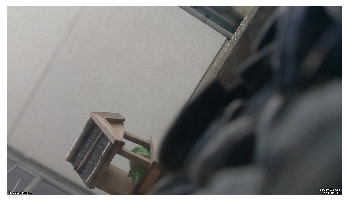

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[0.]]


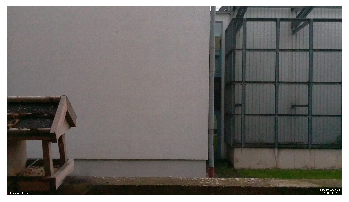

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[0.]]


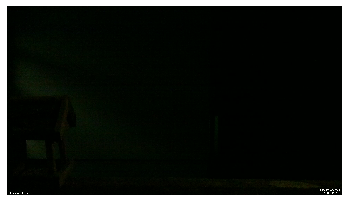

Image 2018-08-25-11-02-29.jpg is identified as not a bird, but should contain a bird
[[0.]]


In [32]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

max_images = 5
positive = [os.path.join(TRAINING_POSITIVE_DIR, fname) for fname in POSITIVE_FILES]
negative = [os.path.join(TRAINING_NEGATIVE_DIR, fname) for fname in NEGATIVE_FILES]

count = 0
for img_path in positive:
  if count == max_images:
    break
  img = image.load_img(img_path, target_size=(1080, 1920))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if classes != 0.0:
    count += 1
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    print("Image {} is identified as not a bird, but should contain a bird".format(fn))
    print(classes)

count = 0
for img_path in negative:
  if count == max_images:
    break
  img = image.load_img(img_path, target_size=(1080, 1920))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if classes != 1.0:
    count += 1
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    print("Image {} is identified as containing a bird, but should not contain one".format(fn))
    print(classes)

In [34]:
positive = [os.path.join(TRAINING_POSITIVE_DIR, fname) for fname in POSITIVE_FILES]
negative = [os.path.join(TRAINING_NEGATIVE_DIR, fname) for fname in NEGATIVE_FILES]

count_pos_correct = 0
count_pos_incorrect = 0
for img_path in positive:
  img = image.load_img(img_path, target_size=(1080, 1920))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  if classes == 0.0:
    count_pos_correct += 1
  else:
    count_pos_incorrect += 1

print("{} positive images were correctly identified as having a bird, and {} were incorrectly identified as not having one.".format(count_pos_correct, count_pos_incorrect))

count_neg_correct = 0
count_neg_incorrect = 0
for img_path in negative:
  img = image.load_img(img_path, target_size=(1080, 1920))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=batch_size)
  if classes == 1.0:
    count_neg_correct += 1
  else:
    count_neg_incorrect += 1

print("{} negative images were correctly identified as not having a bird, and {} were incorrectly identified as having one.".format(count_neg_correct, count_neg_incorrect))
print("Total accuracy (correct/total): {}.".format((count_pos_correct+count_neg_correct)/(count_pos_correct+count_neg_correct+count_pos_incorrect+count_neg_incorrect)))


2258 positive images were correctly identified as having a bird, and 48 were incorrectly identified as not having one.
2582 negative images were correctly identified as not having a bird, and 212 were incorrectly identified as having one.
Total accuracy (correct/total): 0.9490196078431372.


The code below receives an uploaded image and uses the model to predict the output.

In [45]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(1080, 1920))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=batch_size)
  print(fn)
  print(classes)
  print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(classes)])

Saving 2018-08-29-06-59-25.jpg to 2018-08-29-06-59-25.jpg
2018-08-29-06-59-25.jpg
[[0.]]
birds


In [20]:
incorrects = np.nonzero(model.predict(validation_generator).reshape((-1,)) != validation_generator.labels)

incorrects

(array([   0,    1,    2, ..., 2182, 2183, 2185]),)